# Sarter Notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Reading Data

In [408]:
# read train data
df_data = pd.read_csv("Datasets.csv", sep=",")
df_data.head()
df_data.isnull().sum()

order_id                    0
origin_port                 0
3pl                         0
customs_procedures          0
logistic_hub             1049
customer                    0
product_id                  0
units                       0
late_order                  0
weight                    118
material_handling         118
origin_port_coord       50098
logistic_hub_coord      50098
dist_origin_hub         50098
customer_coord           2531
dist_hub_customer        2531
dist_origin_customer    38202
dtype: int64

# Clean the data

In [437]:
df_data["origin_port"] = df_data["origin_port"].replace(["ATHENAS"], "Athens")
df_data["origin_port"] = df_data["origin_port"].replace(["BCN"], "Barcelona")
df_data["late_order"] = df_data["late_order"].astype(int)

logistic_hub
Bratislava     4491
Dusseldorf    12518
Hamburg       21480
Liege          4641
Lille         10248
Rome          12460
Venlo         23700
Warsaw        15803
Zaragoza       7886
Name: order_id, dtype: int64


# Analaize the data

In [435]:
counts0 = df_data["order_id"].groupby(df_data["customer"]).count()
print(counts0.sort_values(ascending=False))

customer
Berlin        9819
Milan         9670
Madrid        9231
Vienna        7080
Paris         6606
Munich        6047
Amsterdam     5413
Stockholm     4926
Copenhagen    4877
Lyon          4863
Barcelona     4386
Cologne       3904
Rome          3860
Marseille     3842
Bucharest     3352
Athens        3143
Budapest      2720
Naples        2680
Hanover       2250
Malmö         2163
Turin         2143
Lisbon        2110
Valencia      1638
Bordeaux      1621
Prague        1620
Bremen        1612
Helsinki      1588
Porto         1112
Name: order_id, dtype: int64


In [416]:
counts1 = df_data["late_order"].groupby(df_data["3pl"]).value_counts()
# For every 3pl, print the percentage of late orders
for i in range(1, 5):
    print(f"v_00{i}", ":", counts1[f"v_00{i}"][0]/(counts1[f"v_00{i}"][0]+counts1[f"v_00{i}"][1]))

v_001 : 0.6179014667168108
v_002 : 0.8005533611227406
v_003 : 0.7497475840184624
v_004 : 0.7430507101217673


In [415]:
counts2 = df_data["late_order"].groupby(df_data["customs_procedures"]).value_counts()
# For every custom_procedures, print the percentage of late orders
for name in ["CRF", "DTD", "DTP"]:
   print(name, ":", counts2[name][0]/(counts2[name][0]+counts2[name][1]))

CRF : 0.801794976397226
DTD : 0.7485051973139546
DTP : 0.6884804556044525


In [277]:
counts3 = df_data["customs_procedures"].groupby(df_data["3pl"]).value_counts()
print(counts3)

3pl    customs_procedures
v_001  CRF                    3686
       DTD                    2960
       DTP                    1331
v_002  CRF                   24595
       DTD                   21035
       DTP                    9307
v_003  CRF                    3103
       DTD                    2658
       DTP                    1172
v_004  CRF                   20093
       DTD                   16831
       DTP                    7505
Name: customs_procedures, dtype: int64


# ML

### Split the data

In [278]:
import sklearn as sk

### Decision trees

In [443]:
X = df_data.drop(['order_id', 'product_id', "logistic_hub", "customer", 'dist_origin_hub',
                  "origin_port_coord", "logistic_hub_coord", "customer_coord", "dist_hub_customer", 
                  "dist_origin_customer", 'material_handling'], axis=1).dropna()
print(X.head())
y = X['late_order']
X = X.drop(['late_order'], axis=1)
X["massat"] = X['weight']*X['units']
X = X.drop(["weight", 'units'], axis=1)

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
X_train_enc = pd.get_dummies(X_train, columns=["origin_port", "3pl", "customs_procedures"])
X_test_enc = pd.get_dummies(X_test, columns=["origin_port", "3pl", "customs_procedures"])
print(X_train_enc.iloc(0)[7])

  origin_port    3pl customs_procedures  units  late_order  weight
0   Rotterdam  v_002                DTP    583           1  1778.0
1   Rotterdam  v_004                CRF    459           0  1088.0
2      Athens  v_002                CRF    464           1   505.0
3   Rotterdam  v_004                CRF    678           0  1308.0
4   Barcelona  v_002                CRF    353           0  1465.0
massat                    408153.0
origin_port_Athens             0.0
origin_port_Barcelona          0.0
origin_port_Rotterdam          1.0
3pl_v_001                      0.0
3pl_v_002                      0.0
3pl_v_003                      0.0
3pl_v_004                      1.0
customs_procedures_CRF         0.0
customs_procedures_DTD         1.0
customs_procedures_DTP         0.0
Name: 38440, dtype: float64


In [444]:
from sklearn.tree import DecisionTreeClassifier
xval = [i for i in range(2, 18)]
yval = [None for _ in range(2, 18)]
for i in range(2, 18):
    modelt = DecisionTreeClassifier(criterion="entropy", max_depth=i)
    modelt.fit(X_train_enc, y_train)
    y_pred = modelt.predict(X_test_enc)
    yval[i-2] = sk.metrics.accuracy_score(y_pred, y_test)


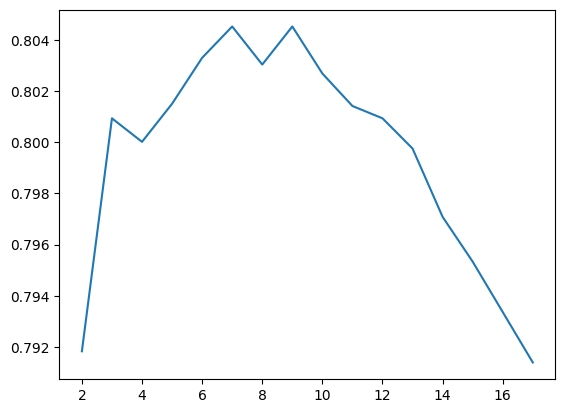

In [445]:
plt.plot(xval,yval)

In [354]:
print(max(yval))

False


[Text(0.6004023203592814, 0.9545454545454546, 'X[0] <= 1061038.5\nentropy = 0.79\nsamples = 90487\nvalue = [69060, 21427]'),
 Text(0.32761040419161674, 0.8636363636363636, 'X[3] <= 0.5\nentropy = 0.726\nsamples = 84670\nvalue = [67552, 17118]'),
 Text(0.14612649700598804, 0.7727272727272727, 'X[0] <= 228737.0\nentropy = 0.872\nsamples = 36515\nvalue = [25825, 10690]'),
 Text(0.055089820359281436, 0.6818181818181818, 'X[2] <= 0.5\nentropy = 0.937\nsamples = 2126\nvalue = [750, 1376]'),
 Text(0.028517964071856288, 0.5909090909090909, 'X[0] <= 103016.0\nentropy = 0.841\nsamples = 1157\nvalue = [312, 845]'),
 Text(0.01347305389221557, 0.5, 'X[8] <= 0.5\nentropy = 0.634\nsamples = 363\nvalue = [58, 305]'),
 Text(0.007784431137724551, 0.4090909090909091, 'X[16] <= 0.5\nentropy = 0.438\nsamples = 210\nvalue = [19, 191]'),
 Text(0.004790419161676647, 0.3181818181818182, 'X[0] <= 101455.0\nentropy = 0.393\nsamples = 194\nvalue = [15, 179]'),
 Text(0.003592814371257485, 0.22727272727272727, 'X[0

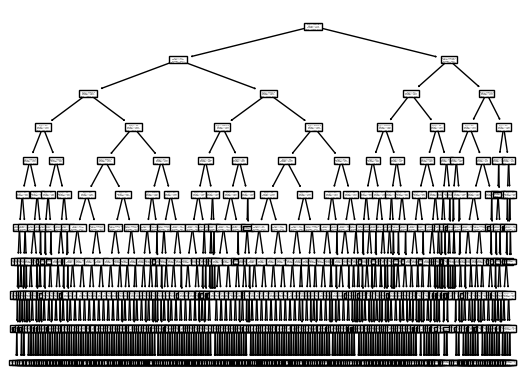

In [355]:
from sklearn.tree import plot_tree
modelt = DecisionTreeClassifier(criterion="entropy", max_depth=10)
modelt.fit(X_train_enc, y_train)
plot_tree(modelt)

## Save Solution
> **Note:** Submited probabilities must be for the **True** cases.

In [ ]:
submission = pd.DataFrame({"order_id": X_test.order_id, "late_order": pred_proba[:,1]})
submission.to_csv("submission_kaggle.csv", index=False)